## **Resizing**

In [ ]:
# Import necessary libraries
from PIL import Image
import os

# Define paths for images and masks
images_path = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/ORIGA&RIMONEDL_IMG_Masks/Images/"
masks_path = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/ORIGA&RIMONEDL_IMG_Masks/Masks/"
resized_images_path = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/ORIGA&RIMONEDL_Resized_IMG_Masks/Resized_Images/"
resized_masks_path = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/ORIGA&RIMONEDL_Resized_IMG_Masks/Resized_Masks/"


# Define target size for resizing images and masks
target_size = (128, 128)

# Get list of image and mask files
images = sorted(os.listdir(images_path))
masks = sorted(os.listdir(masks_path))

# Iterate over image and mask pairs
for image_name, mask_name in zip(images, masks):
    image_path = os.path.join(images_path, image_name)
    mask_path = os.path.join(masks_path, mask_name)

    # Open image and mask files
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Resize image and mask
    resized_image = image.resize(target_size, Image.ANTIALIAS) #The Image.ANTIALIAS argument is used for resizing the image, while Image.
    resized_mask = mask.resize(target_size, Image.NEAREST) #NEAREST is used for resizing the mask to preserve the pixel values.

    # Save the resized images and masks
    resized_image.save(os.path.join(resized_images_path, os.path.splitext(image_name)[0] + ".png"), "PNG")
    resized_mask.save(os.path.join(resized_masks_path, os.path.splitext(mask_name)[0] + ".png"), "PNG")


# **Augmentation**

In [ ]:
# Install albumentations library
!pip install albumentations

In [ ]:
# Import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp, resize
from skimage import io, img_as_ubyte
import random
import os
from scipy.ndimage import rotate
import cv2

import albumentations as A

images_to_generate = 1360 #2040

images_path = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/ORIGA&RIMONEDL_Resized_IMG_Masks/Resized_Images/"
masks_path = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/ORIGA&RIMONEDL_Resized_IMG_Masks/Resized_Masks/"

# Define paths for augmented images and masks
img_augmented_path = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/ORIGA&RIMONEDL_after_augmentation_version_1/Images/"
msk_augmented_path = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/ORIGA&RIMONEDL_after_augmentation_version_1/Masks/"


# Get list of image and mask IDs
image_ids = [os.path.splitext(im)[0] for im in os.listdir(images_path)]
mask_ids = [os.path.splitext(msk)[0] for msk in os.listdir(masks_path)]

# Find common IDs between images and masks
common_ids = list(set(image_ids) & set(mask_ids))

# Define augmentation pipeline
aug = A.Compose([
    A.Rotate(limit=10, p=0.5),
    #A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.2),
    A.HorizontalFlip(p=1)
])

# Initialize counters and lists for augmented images and masks
i = 1
augmented_images = []
augmented_masks = []

# Generate augmented images and masks
while i <= images_to_generate:
    # Select a common ID
    common_id = random.choice(common_ids)
    # Construct full file paths
    image = os.path.join(images_path, common_id + ".png")
    mask = os.path.join(masks_path, common_id + ".png")
    print(image, mask)
    # Open image and mask files
    original_image = io.imread(image)
    original_mask = io.imread(mask)

    image_shape = original_image.shape[:2]
    mask_shape = original_mask.shape[:2]
    # Check if image and mask have the same shape
    if image_shape != mask_shape:
        raise ValueError("Height and Width of image and mask should be equal.")
    # Apply augmentations
    augmented = aug(image=original_image, mask=original_mask)
    transformed_image = augmented['image']
    transformed_mask = augmented['mask']

    # Construct file paths for augmented images and masks
    new_image_path = "%s/augmented_image_%s.png" % (img_augmented_path, i)
    new_mask_path = "%s/augmented_mask_%s.png" % (msk_augmented_path, i)
    # Save augmented images and masks
    io.imsave(new_image_path, transformed_image)
    io.imsave(new_mask_path, transformed_mask)

    # Append augmented images and masks to lists
    augmented_images.append(transformed_image)
    augmented_masks.append(transformed_mask)
    # Increment counter
    i += 1


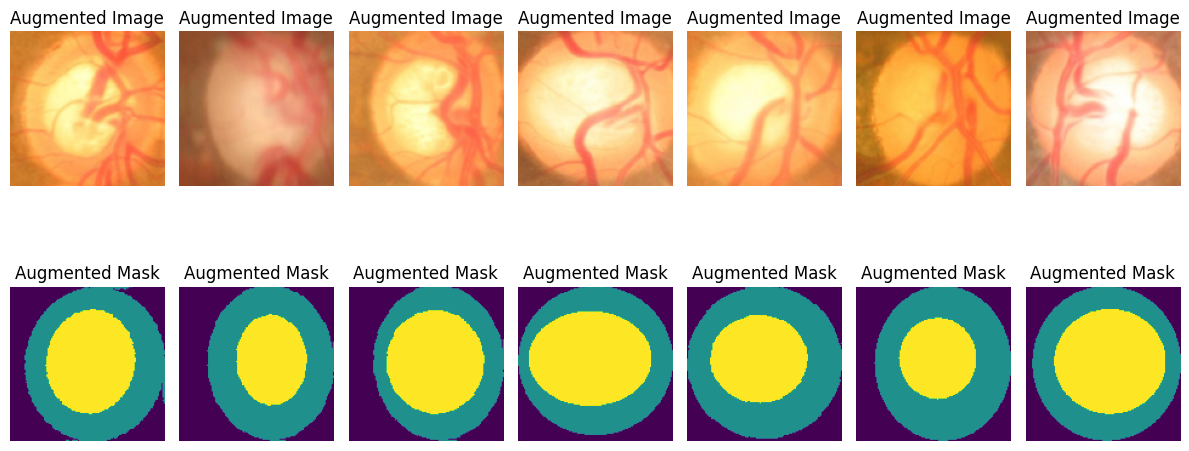

In [ ]:
# Visualize some of the augmented images with their corresponding masks
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(12, 6)) #r=2, c=5
for i in range(7):
    random_index = random.randint(0, len(augmented_images) - 1)
    axes[0, i].imshow(augmented_images[random_index].astype(np.uint8))
    axes[0, i].set_title("Augmented Image")
    axes[0, i].axis("off")

    axes[1, i].imshow(augmented_masks[random_index].astype(np.uint8))
    axes[1, i].set_title("Augmented Mask")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


# **Denoising**

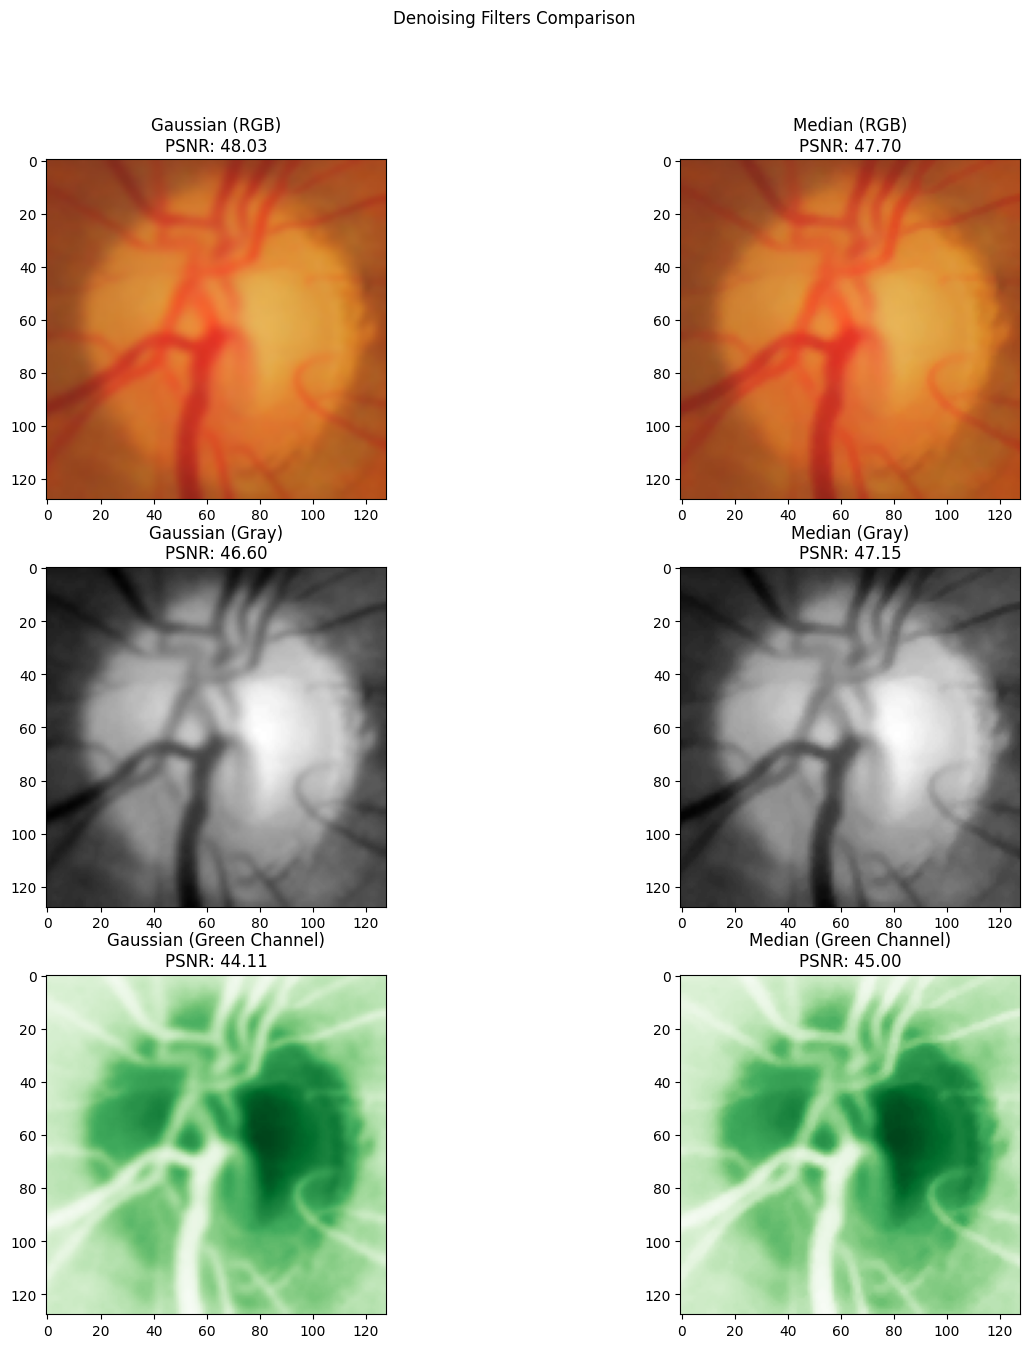

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define a function to calculate the Peak Signal-to-Noise Ratio (PSNR)
def psnr(original, processed):
    mse = np.mean((original - processed) ** 2)
    max_pixel = np.max(original)
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# Load RGB fundus image
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/ORIGA&RIMONEDL_Resized_IMG_Masks/Resized_Images/r2_Im429.png')

# Convert image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Split image into channels
b, g, r = cv2.split(image)

# Apply Gaussian filter to RGB image
gaussian_filtered_image = cv2.GaussianBlur(image, (3, 3), 0)
# Apply Median filter to RGB image
median_filtered_image = cv2.medianBlur(image, 3)

# Apply Gaussian filter to grayscale image
gaussian_filtered_gray_image = cv2.GaussianBlur(gray_image, (3, 3), 0)
# Apply Median filter to grayscale image
median_filtered_gray_image = cv2.medianBlur(gray_image, 3)


# Apply Gaussian filter to green channel
gaussian_filtered_green_channel = cv2.GaussianBlur(g, (3, 3), 0)
# Apply Median filter to green channel
median_filtered_green_channel = cv2.medianBlur(g, 3)

# Calculate PSNR for each case
psnr_gaussian_rgb = psnr(image.astype(float), gaussian_filtered_image.astype(float))
psnr_median_rgb = psnr(image.astype(float), median_filtered_image.astype(float))

psnr_gaussian_gray = psnr(gray_image.astype(float), gaussian_filtered_gray_image.astype(float))
psnr_median_gray = psnr(gray_image.astype(float), median_filtered_gray_image.astype(float))

psnr_gaussian_green_channel = psnr(g.astype(float), gaussian_filtered_green_channel.astype(float))
psnr_median_green_channel = psnr(g.astype(float), median_filtered_green_channel.astype(float))

# Display images and PSNR values in a comparison chart
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

fig.suptitle('Denoising Filters Comparison')

axs[0, 0].imshow(cv2.cvtColor(gaussian_filtered_image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title(f'Gaussian (RGB)\nPSNR: {psnr_gaussian_rgb:.2f}')

axs[0, 1].imshow(cv2.cvtColor(median_filtered_image, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title(f'Median (RGB)\nPSNR: {psnr_median_rgb:.2f}')

axs[1, 0].imshow(gaussian_filtered_gray_image, cmap='gray')
axs[1, 0].set_title(f'Gaussian (Gray)\nPSNR: {psnr_gaussian_gray:.2f}')

axs[1,1].imshow(median_filtered_gray_image, cmap='gray')
axs[1,1].set_title(f'Median (Gray)\nPSNR: {psnr_median_gray:.2f}')



axs[2, 0].imshow(gaussian_filtered_green_channel, cmap='Greens')
axs[2, 0].set_title(f'Gaussian (Green Channel)\nPSNR: {psnr_gaussian_green_channel:.2f}')

axs[2,1].imshow(median_filtered_green_channel, cmap='Greens')
axs[2,1].set_title(f'Median (Green Channel)\nPSNR: {psnr_median_green_channel:.2f}')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Denoising/graphes/RIMONEDL_images and PSNR_kernel_3_graph.png')
plt.show()